In [1]:
import os
import sys
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
from scipy.signal import welch, firwin, filtfilt, hilbert
from time import gmtime

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
sys.path.insert(0, '/Users/wassilyminkow/Scripts/Python3/')

from Neuroinformatics.torpor_project.data import *
from Neuroinformatics.math.pandas.statistics import *
from Neuroinformatics.data.pandas.time_series import TimeSeries
from Neuroinformatics.math.curves import *
from Neuroinformatics.math.regression import *

In [3]:
pylab.rcParams['figure.figsize'] = (22, 18)
sns.set(font_scale=2.5)

dG - отклонение ускорения в момент измерения от 0 (ускорения свободного падения); если животное падает, то ускорение животного равно G и соответственно dG будет равно 1

dF1, dF2 - изменение направления вектора ускорения, причем dF1 - изменение за время между двумя измерениями (1 минута), а  dF2 - изменение между двумя измерениями с интервалом 1 мс - если оно не равно 0, то обычно животное изменяет свое положение.
 
Все показатели измеряются раз в минуту, если период измерения  указан больше, чем минута, то показатели усредняются за этот период. Если надо, то изготовитель может прислать точную формулу расчета этих показателей.

In [4]:
polygraphy_file = "/Users/wassilyminkow/Data/Hamster_Data/hamster_without_torpor/hamster_without_torpor.csv"
eeg_path = "/Users/wassilyminkow/Data/Hamster_Data/hamster_without_torpor/hamster_1_records/"
data = pd.read_csv(polygraphy_file)

In [5]:
min_per_epoch = 10
order = 400 # filter order
a = 1 
bands = np.array([[1, 4], [4, 8]])
data["EEG"] = 0
chans = ["Channel 1", "Channel 2"]
kinds = ["Power", 
         "Power {}-{}".format(bands[0,0], bands[0,1]), 
         "Power {}-{}".format(bands[1,0], bands[1,1])
        ]

for chan in chans:
    for kind in kinds:
        data["{} {}".format(chan, kind)] = np.nan
        
for name in os.listdir(eeg_path):

    # read EEG and acceleration data
    raw_data = mne.io.read_raw_edf(eeg_path+name)
    fs = round(raw_data.info['sfreq'])
    df = pd.DataFrame(raw_data.get_data([0, 1]), index=[chans[0], chans[1]]).T
        
    # get the time when the recording was started
    start = list(gmtime(raw_data.info['meas_date'][0]))

    # Calculate number of samples to skip till the begining of the epoch. 
    # This step is needed due to the fact, that EEG recording starts not at the same time as polygraph recording. 
    n_skip, corrected_start_time = count_damaged_samples(start, fs, 5)

    # Skip damaged samples at the begining
    df_new = df.iloc[n_skip:, ]

    # Calculate # of polygraphy epochs and correspotding # of EEG samples for the  EEG file
    n_epocs = int(np.floor(df_new.shape[0]/fs/SEC_PER_MIN/min_per_epoch))
    n_samples = int(n_epocs*min_per_epoch*SEC_PER_MIN*fs)

    # Skip damaged samples at the ending
    df_epocs = df_new.iloc[:n_samples, :]

    # Find start epoch index
    start_epoc = data[
        (data['Year']==start[0]) &
        (data['Month']==start[1])&
        (data['Day']==start[2])  &
        (data['Hour']==start[3]) &
        (data['Minute']==start[4])
        ].index[0]
    
    # Polygraphy epoch length in EEG samples.
    step = fs*SEC_PER_MIN*min_per_epoch

    for chan in chans:
        
        b = firwin(order, bands[0, :] * 2 / fs, width=None, window='hamming', pass_zero=False) # design filter
        df_epocs_low = filtfilt(b, a, df_epocs[chan].iloc[:]) # apply filter

        b = firwin(order, bands[1, :] * 2 / fs, width=None, window='hamming', pass_zero=False) # design filter
        df_epocs_hi = filtfilt(b, a, df_epocs[chan].iloc[:])

        sum_power = np.array(list(map(lambda i: (df_epocs[chan].iloc[i*step:(i+1)*step]**2).mean(), np.arange(n_epocs))))
        sum_power_low = np.array(list(map(lambda i: (df_epocs_low[i*step:(i+1)*step]**2).mean(), np.arange(n_epocs))))
        sum_power_hi = np.array(list(map(lambda i: (df_epocs_hi[i*step:(i+1)*step]**2).mean(), np.arange(n_epocs))))
        
        data["{} {}".format(chan, kinds[0])].iloc[start_epoc:start_epoc+n_epocs] = sum_power*1e3
        data["{} {}".format(chan, kinds[1])].iloc[start_epoc:start_epoc+n_epocs] = sum_power_low*1e3
        data["{} {}".format(chan, kinds[2])].iloc[start_epoc:start_epoc+n_epocs] = sum_power_hi*1e3
        
        del df_epocs_low, df_epocs_hi, sum_power_low, sum_power_hi, sum_power
        
    del raw_data, df, df_new

Extracting EDF parameters from /Users/wassilyminkow/Data/Hamster_Data/hamster_without_torpor/hamster_1_records/31-01-2019_13-39.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-5-63c003ffcb6e>:19: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(eeg_path+name)
/Users/wassilyminkow/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


KeyboardInterrupt: 

In [6]:
gap = 6*12
acceleration = np.asanyarray(((data["dG"]).rolling(gap).mean().dropna()))
temperature = np.asanyarray(((data["T"]).rolling(gap).mean().dropna()))
time_array = np.asanyarray(data.index[:temperature.shape[0]])/6/24

In [7]:
z = moving_correlation(time_array, temperature, acceleration, gap=6*12)

In [8]:
top = np.max([(standardize(temperature)).max(), (standardize(acceleration)).max()])
bottom = np.min([(standardize(temperature)).min(), (standardize(acceleration)).min()])
skip_start = 0

tech = np.ones(z[0][1][:].shape[0])

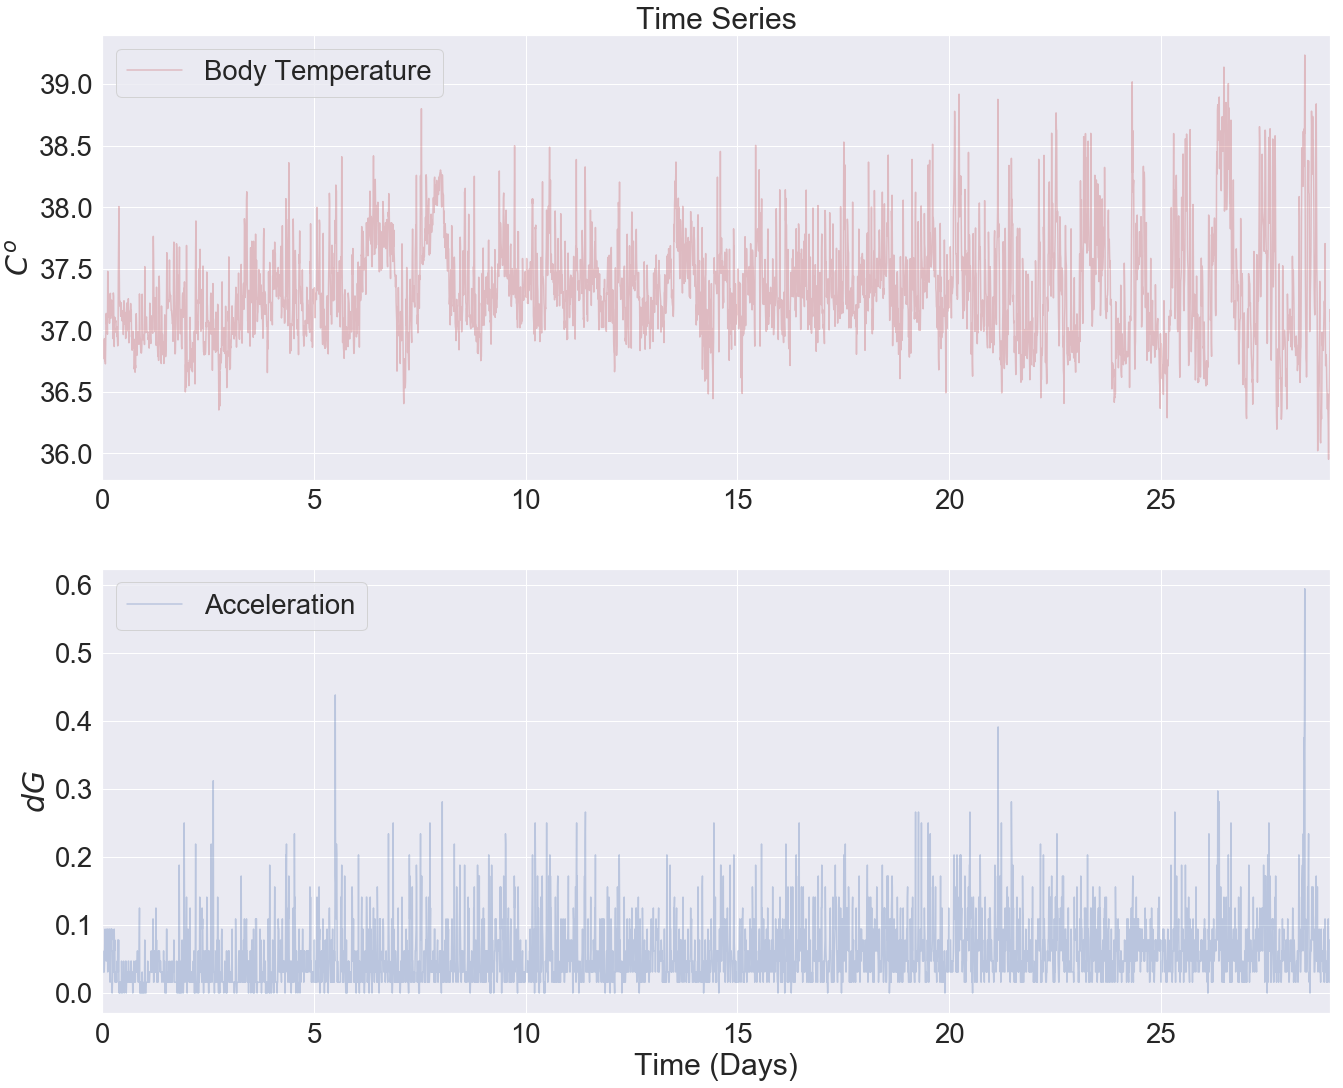

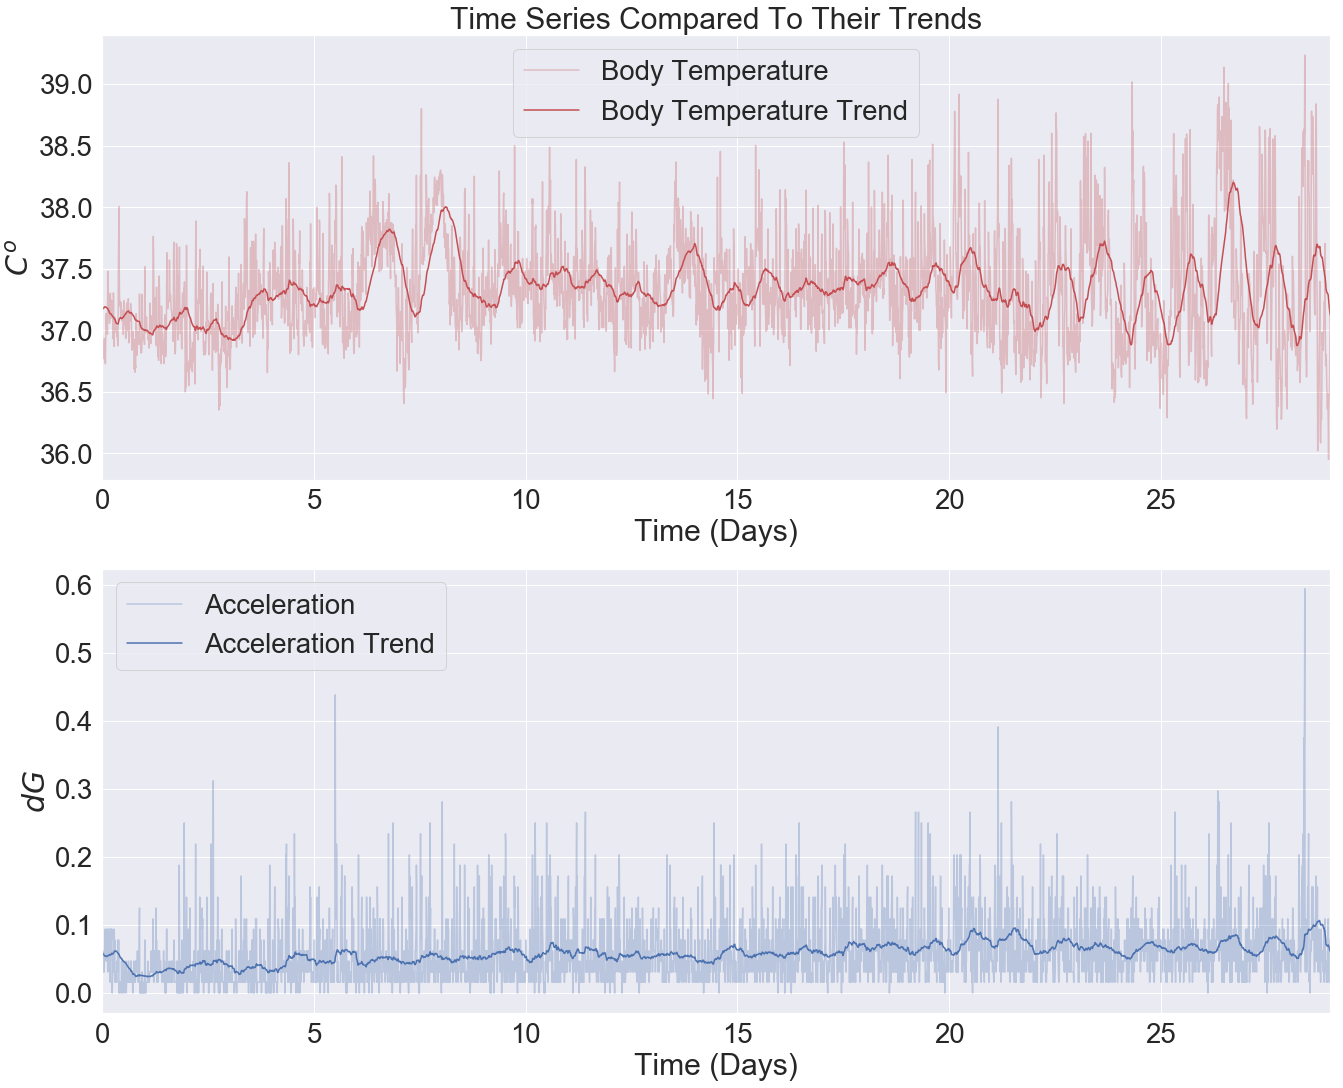

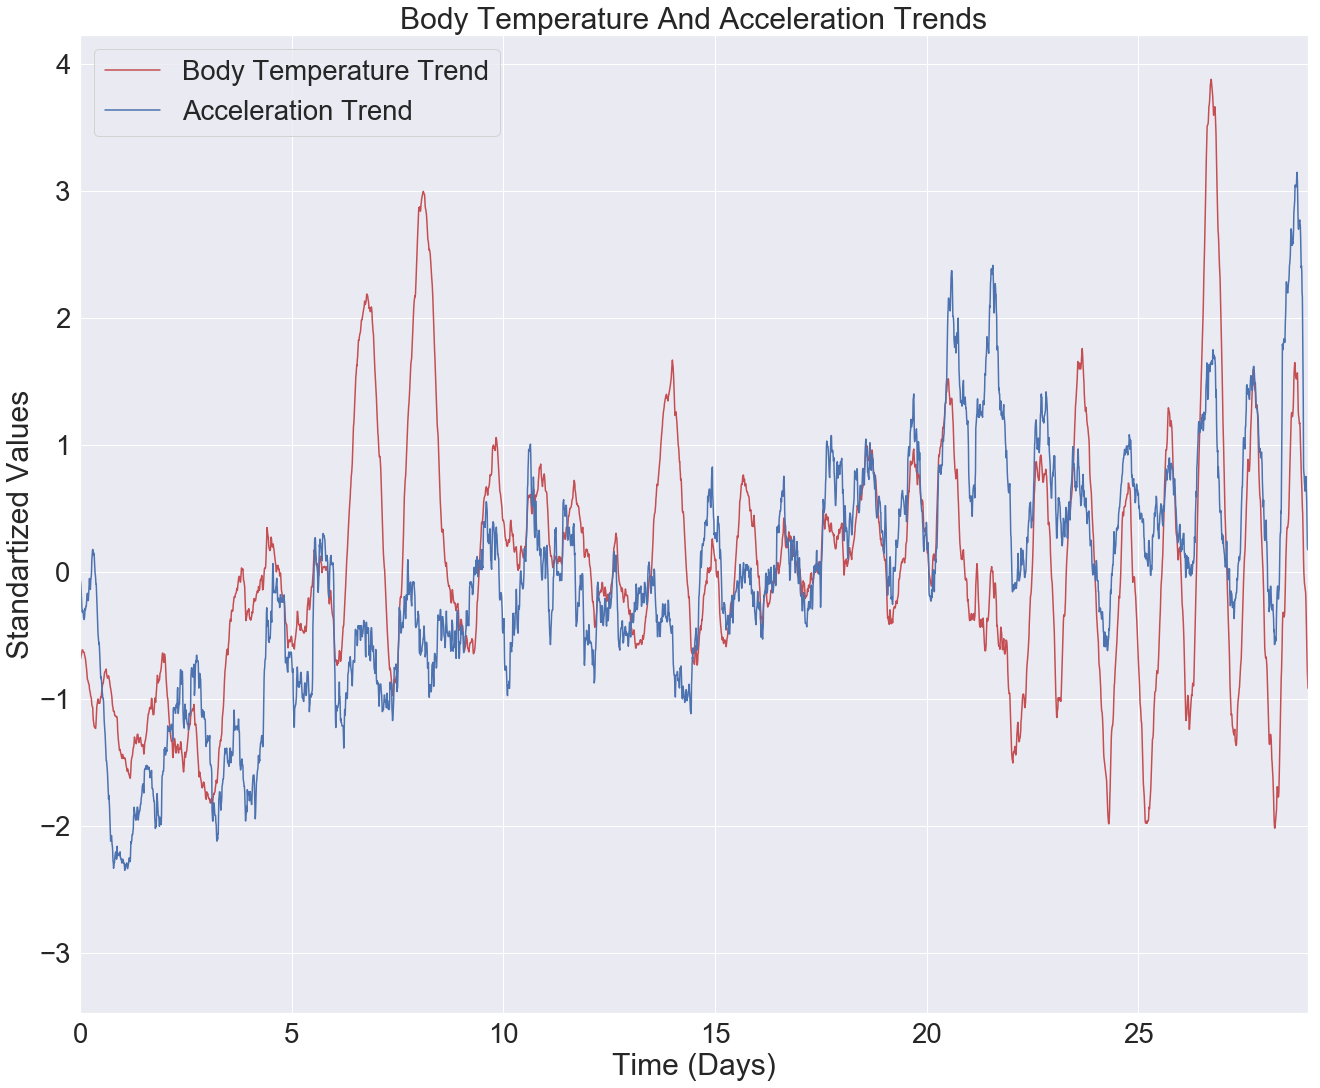

[]

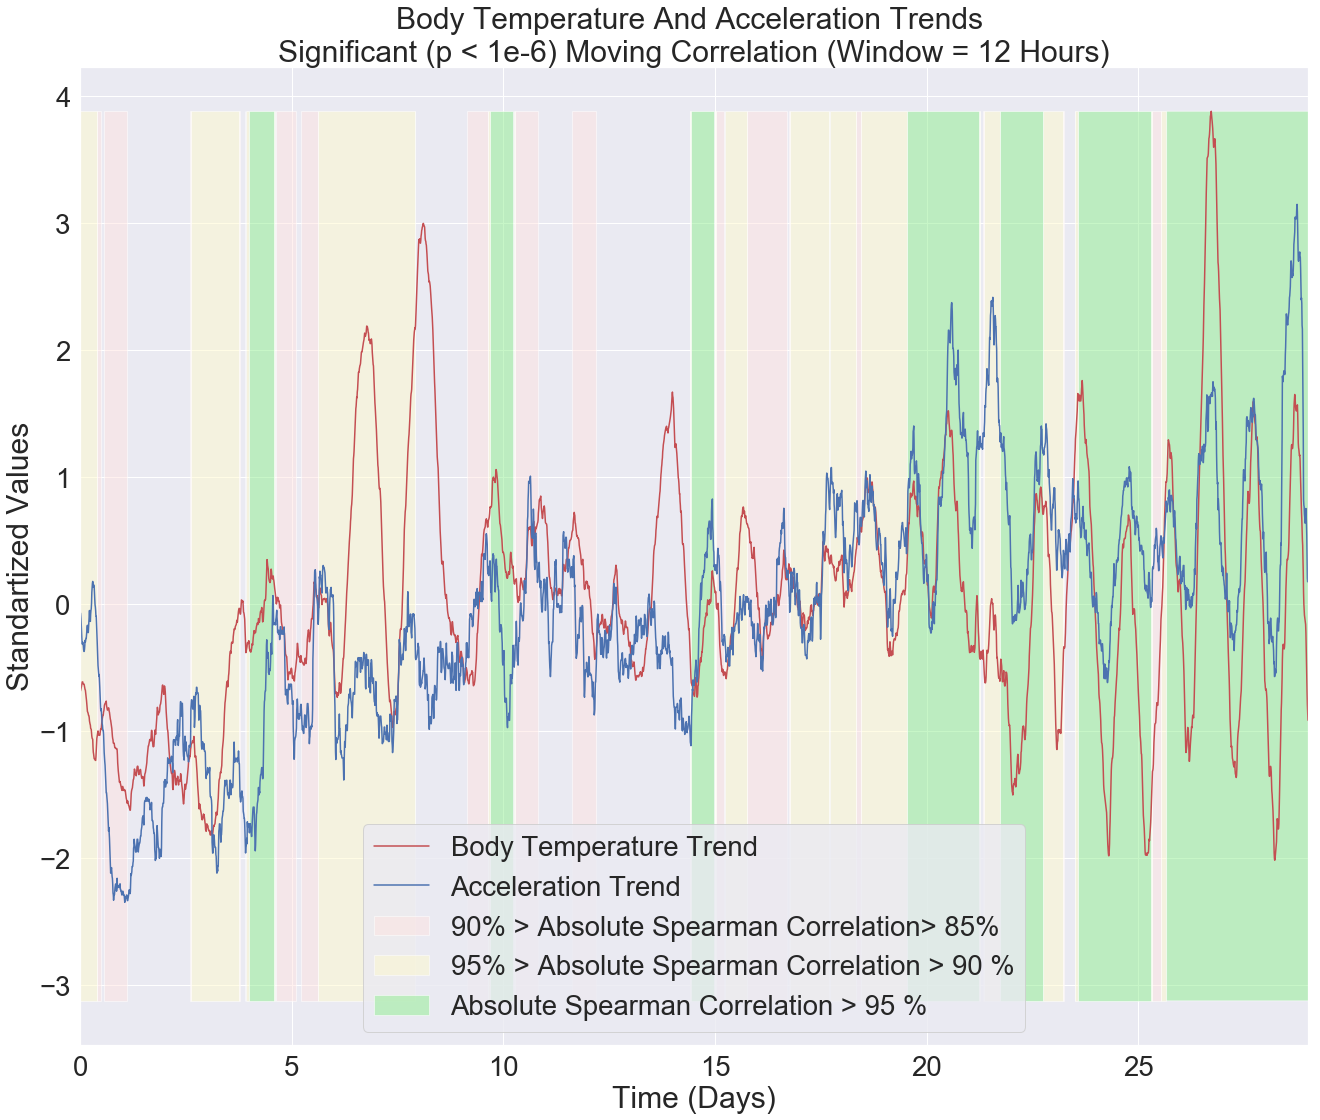

In [9]:
subplot(2,1,1)
plot(time_array, data['T'][gap-1:], "r", alpha=0.3, label="Body Temperature")
title("Time Series")
ylabel(r"$C^o$")
# xlabel("Time (Days)")
legend(loc="best")
plt.xlim([0, 29])

subplot(2,1,2)
plot(time_array, data['dG'][gap-1:], "b", alpha=0.3, label=r"Acceleration")
ylabel(r"$dG$")
xlabel("Time (Days)")
legend(loc="best")
plt.xlim([0, 29])
show()

subplot(2,1,1)
plot(time_array, data['T'][gap-1:], "r", alpha=0.3, label="Body Temperature")
plot(time_array, temperature, "r", label="Body Temperature Trend")
title("Time Series Compared To Their Trends")
ylabel(r"$C^o$")
xlabel("Time (Days)")
legend(loc="best")
plt.xlim([0, 29])

subplot(2,1,2)
plot(time_array, data['dG'][gap-1:], "b", alpha=0.3, label=r"Acceleration")
plot(time_array, acceleration, "b", label=r"Acceleration Trend")
ylabel(r"$dG$")
xlabel("Time (Days)")
legend(loc="best")
plt.xlim([0, 29])
show()

plt.plot(time_array, standardize(temperature), 'r', label="Body Temperature Trend")
plt.plot(time_array, standardize(acceleration), 'b', label=r"Acceleration Trend")
plt.title("Body Temperature And Acceleration Trends")
plt.ylabel("Standartized Values")
plt.xlabel("Time (Days)")
plt.legend(loc="best")
plt.xlim([0, 29])
plt.plot()
show()

fill_between(z[2][1][:], tech*top, tech*bottom, alpha=0.5, facecolor="mistyrose", label = "90% > Absolute Spearman Correlation> 85%")
fill_between(z[1][1][:], tech*top, tech*bottom, alpha=0.5, facecolor="lemonchiffon", label = "95% > Absolute Spearman Correlation > 90 %")
fill_between(z[0][1][:], tech*top, tech*bottom, alpha=0.5, facecolor="lightgreen", label = "Absolute Spearman Correlation > 95 %")
plot(time_array, standardize(temperature), "r", label="Body Temperature Trend")
plot(time_array, standardize(acceleration), "b", label="Acceleration Trend")
title("Body Temperature And Acceleration Trends \nSignificant (p < 1e-6) Moving Correlation (Window = 12 Hours)")
ylabel("Standartized Values")
xlabel("Time (Days)")
legend(loc="best")
xlim([0, 29])
plot()

(array([432., 418., 410., 459., 451., 429., 430., 421., 420., 448.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

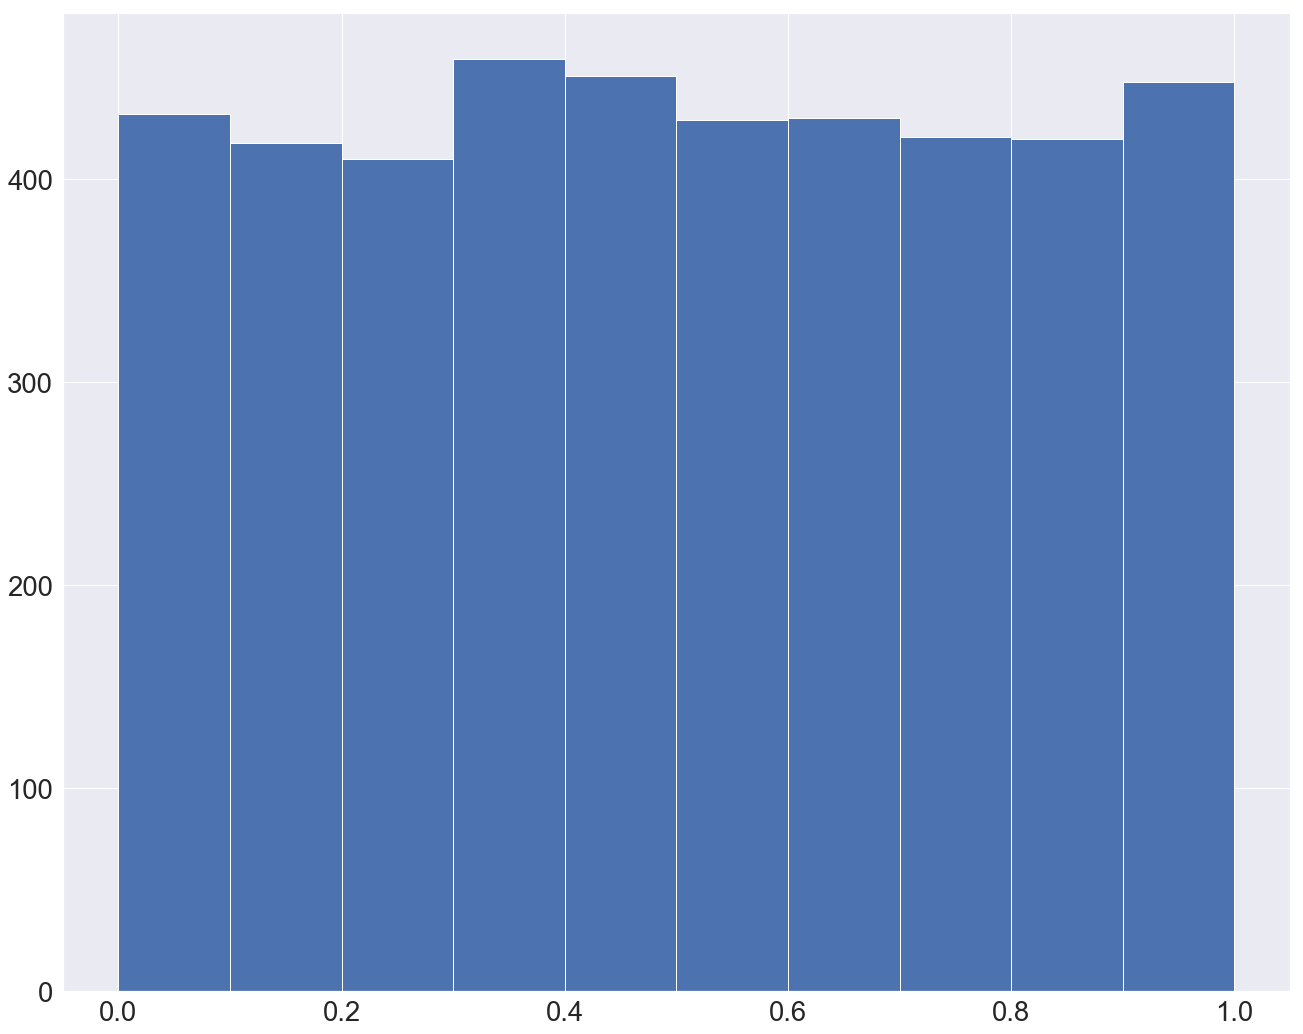

In [11]:
hist(normalize(np.random.rand(time_array.shape[0])))
# plot(np.random.rand(time_array.shape[0]))

Help on built-in function rand:

rand(...) method of mtrand.RandomState instance
    rand(d0, d1, ..., dn)
    
    Random values in a given shape.
    
    Create an array of the given shape and populate it with
    random samples from a uniform distribution
    over ``[0, 1)``.
    
    Parameters
    ----------
    d0, d1, ..., dn : int, optional
        The dimensions of the returned array, should all be positive.
        If no argument is given a single Python float is returned.
    
    Returns
    -------
    out : ndarray, shape ``(d0, d1, ..., dn)``
        Random values.
    
    See Also
    --------
    random
    
    Notes
    -----
    This is a convenience function. If you want an interface that
    takes a shape-tuple as the first argument, refer to
    np.random.random_sample .
    
    Examples
    --------
    >>> np.random.rand(3,2)
    array([[ 0.14022471,  0.96360618],  #random
           [ 0.37601032,  0.25528411],  #random
           [ 0.49313049,  0.94909878]]